In [6]:
# @title Librerías para XGBoost

# Si no tienes xgboost instalado, descomenta la siguiente línea:
# !pip install xgboost

import numpy as np
import pandas as pd

# Modelado y preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelo XGBoost
from xgboost import XGBClassifier


En este primer bloque se cargan todas las librerías necesarias para el análisis.
En particular, se importa `XGBClassifier` desde la librería `xgboost`, junto con
las herramientas de preprocesamiento, métricas y visualización de `scikit-learn`
y `matplotlib`. Con esto dejamos preparado el entorno de trabajo para entrenar y
evaluar un modelo de clasificación con XGBoost.


In [7]:
# @title Cargar y preparar dataset Telco (base)

# 1) Cargar dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("="*70)
print("ABANDONO DE CLIENTES TELCO - DATASET ORIGINAL")
print("="*70)
print(f"Forma del Dataset: {df.shape}")
print("\nPrimeras filas:")
display(df.head())

# 2) Limpieza básica: TotalCharges a numérico
# (en este dataset algunas filas tienen espacios en blanco)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Eliminamos filas donde TotalCharges quedó como NaN
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

print("\nForma del Dataset después de limpiar TotalCharges:", df.shape)

# 3) Definir variable objetivo (Churn: Yes/No -> 1/0)
y = df["Churn"].map({"Yes": 1, "No": 0})

print("\nDistribución de la variable objetivo (Churn):")
print(y.value_counts())

# 4) Definir matriz de características sin codificar (todavía)
#    Sacamos ID de cliente y la propia columna Churn
X_raw = df.drop(columns=["customerID", "Churn"])

print("\nColumnas de X_raw:")
print(X_raw.columns.tolist())

# Vistazo rápido
display(X_raw.head())


ABANDONO DE CLIENTES TELCO - DATASET ORIGINAL
Forma del Dataset: (7043, 21)

Primeras filas:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Forma del Dataset después de limpiar TotalCharges: (7032, 21)

Distribución de la variable objetivo (Churn):
Churn
0    5163
1    1869
Name: count, dtype: int64

Columnas de X_raw:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


En este bloque se carga el dataset Telco Customer Churn desde la URL de IBM y se
realiza una limpieza básica. La variable `TotalCharges` se transforma a formato
numérico y se eliminan las filas con valores faltantes. Luego se define la
variable objetivo `Churn`, codificada a 0 (no churn) y 1 (churn), y se construye
la matriz de características `X_raw`, eliminando el identificador del cliente y
la columna objetivo. Con esto dejamos lista la base para el preprocesamiento.


In [8]:
# @title Codificación de variables y creación de conjuntos de entrenamiento/prueba

from sklearn.model_selection import train_test_split

print("Forma inicial de X_raw:", X_raw.shape)

# 1) Identificar columnas categóricas y numéricas
cat_cols = X_raw.select_dtypes(include=["object"]).columns
num_cols = X_raw.select_dtypes(exclude=["object"]).columns

print("\nColumnas categóricas:")
print(list(cat_cols))

print("\nColumnas numéricas:")
print(list(num_cols))

# 2) One-Hot Encoding (variables dummies) para las categóricas
#    drop_first=True evita colinealidad perfecta y reduce dimensión
X = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)

print("\nForma de X después de get_dummies:", X.shape)

# 3) train_test_split (estratificado en la variable objetivo y)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTamaños de los conjuntos:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")


Forma inicial de X_raw: (7032, 19)

Columnas categóricas:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Columnas numéricas:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Forma de X después de get_dummies: (7032, 30)

Tamaños de los conjuntos:
X_train: (5625, 30)
X_test:  (1407, 30)
y_train: (5625,)
y_test:  (1407,)


En este bloque se identifican las columnas numéricas y categóricas, y se aplica
codificación one-hot (`get_dummies`) a las variables categóricas para poder
utilizarlas en un modelo basado en árboles. A continuación se realiza la
separación de los datos en conjuntos de entrenamiento y prueba mediante
`train_test_split`, manteniendo la proporción de la variable objetivo
(estratificación). Esto produce `X_train`, `X_test`, `y_train` y `y_test`, que
serán usados directamente por el modelo XGBoost.


In [9]:
# @title Entrenamiento del modelo XGBoost y predicciones

from xgboost import XGBClassifier

# 1) Opcional: manejar desbalance de clases calculando scale_pos_weight
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos

print(f"Cantidad de casos 'Churn = 1' en train: {int(n_pos)}")
print(f"Cantidad de casos 'Churn = 0' en train: {int(n_neg)}")
print(f"scale_pos_weight (neg/pos): {scale_pos_weight:.3f}")

# 2) Definir el modelo XGBoost
xgb_clf = XGBClassifier(
    n_estimators=300,          # número de árboles
    learning_rate=0.1,        # tasa de aprendizaje
    max_depth=4,              # profundidad máxima de cada árbol
    subsample=0.8,            # muestreo fila
    colsample_bytree=0.8,     # muestreo columnas
    objective="binary:logistic",
    eval_metric="logloss",    # métrica interna
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight  # para desbalance
)

# 3) Entrenar el modelo
xgb_clf.fit(X_train, y_train)

print("\nModelo XGBoost entrenado correctamente.")

# 4) Predicciones sobre el conjunto de prueba
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

print("\nEjemplo de primeras predicciones (clase):")
print(y_pred[:10])

print("\nEjemplo de primeras probabilidades de churn:")
print(y_proba[:10])


Cantidad de casos 'Churn = 1' en train: 1495
Cantidad de casos 'Churn = 0' en train: 4130
scale_pos_weight (neg/pos): 2.763

Modelo XGBoost entrenado correctamente.

Ejemplo de primeras predicciones (clase):
[0 1 0 0 0 1 0 0 1 0]

Ejemplo de primeras probabilidades de churn:
[0.00645585 0.8419761  0.07393584 0.06882405 0.3584272  0.7436609
 0.11999889 0.12458214 0.82286304 0.00391547]


En este bloque se entrena el modelo XGBoost. Primero se calcula el parámetro
`scale_pos_weight` para compensar el desbalance entre las clases de churn y
no-churn. Luego se define un `XGBClassifier` con un conjunto de hiperparámetros
básicos (número de árboles, profundidad máxima, tasa de aprendizaje, etc.) y se
ajusta el modelo usando el conjunto de entrenamiento. Finalmente, se generan las
predicciones de clase (`y_pred`) y las probabilidades de churn (`y_proba`) sobre
el conjunto de prueba, que serán evaluadas en el siguiente bloque.


Accuracy en test: 0.7434

Classification report (XGBoost):
              precision    recall  f1-score   support

           0     0.8934    0.7386    0.8087      1033
           1     0.5118    0.7567    0.6106       374

    accuracy                         0.7434      1407
   macro avg     0.7026    0.7477    0.7096      1407
weighted avg     0.7920    0.7434    0.7560      1407

Matriz de confusión:
              Predicho 0  Predicho 1
No Churn (0)         763         270
Churn (1)             91         283


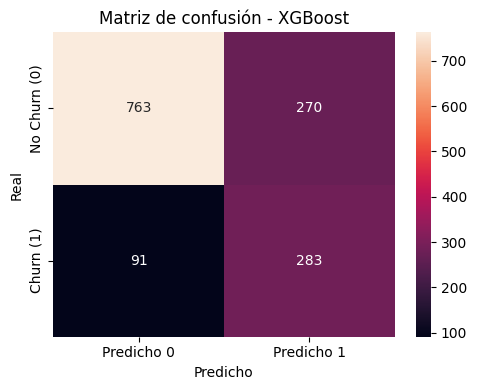


ROC-AUC en test: 0.8236


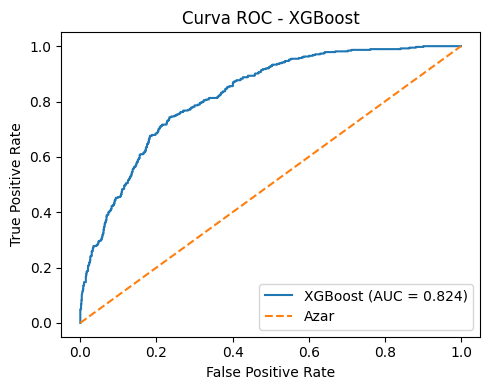

In [10]:
# @title Métricas de desempeño para XGBoost

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {acc:.4f}")

# Classification report
print("\nClassification report (XGBoost):")
print(classification_report(y_test, y_pred, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["No Churn (0)", "Churn (1)"],
                        columns=["Predicho 0", "Predicho 1"])

print("Matriz de confusión:")
print(cm_df)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Matriz de confusión - XGBoost")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.tight_layout()
plt.show()

# ROC-AUC
auc = roc_auc_score(y_test, y_proba)
print(f"\nROC-AUC en test: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Azar")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.tight_layout()
plt.show()


En este bloque se evalúa el desempeño del modelo XGBoost. Se calcula la métrica
de `accuracy` y se muestra el `classification_report`, que resume precisión,
recall y F1-score para cada clase. Además, se construye y grafica la matriz de
confusión para visualizar los aciertos y errores del modelo. Finalmente, se
obtiene el valor de ROC-AUC y se grafica la curva ROC, lo que permite medir la
capacidad del modelo para discriminar entre clientes que harán churn y los que
no, a diferentes umbrales de decisión.


Top 20 variables más importantes según XGBoost:


,0
Contract_Two year,0.292280
InternetService_Fiber optic,0.124429
Contract_One year,0.122148
InternetService_No,0.102111
OnlineSecurity_No internet service,0.032727
StreamingMovies_Yes,0.029355
PaymentMethod_Electronic check,0.026139
tenure,0.021038
MultipleLines_No phone service,0.020206
OnlineSecurity_Yes,0.019326


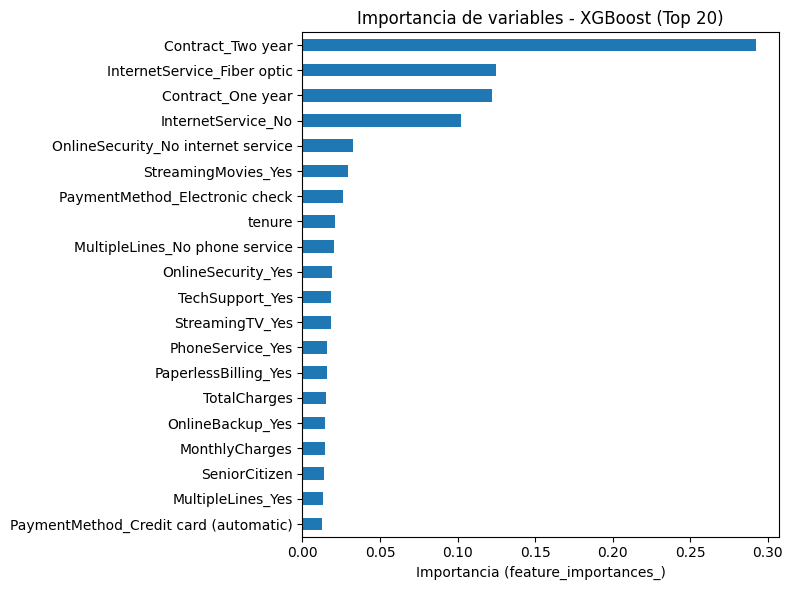

In [ ]:
# @title Importancia de variables (feature importance) en XGBoost

# 1) Serie con la importancia de cada feature
importances = pd.Series(
    xgb_clf.feature_importances_,
    index=X_train.columns
)

# 2) Ordenar de mayor a menor
importances_sorted = importances.sort_values(ascending=False)

print("Top 20 variables más importantes según XGBoost:")
display(importances_sorted.head(20))

# 3) Gráfico de barras (top 20)
top_n = 20
plt.figure(figsize=(8, 6))
importances_sorted.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()  # para que la más importante quede arriba
plt.title(f"Importancia de variables - XGBoost (Top {top_n})")
plt.xlabel("Importancia (feature_importances_)")
plt.tight_layout()
plt.show()


### Conclusiones del modelo XGBoost para Churn

El modelo XGBoost entrenado sobre el dataset Telco alcanza un **accuracy de aproximadamente 0.74** en el conjunto de prueba y un **ROC-AUC cercano a 0.82**, lo que indica una buena capacidad global para distinguir entre clientes que abandonan y los que permanecen. En particular, el modelo presenta un **recall para la clase “Churn = 1” de ~0.76**, es decir, logra identificar cerca de tres cuartas partes de los clientes que efectivamente se dan de baja, aunque a costa de cometer una cantidad importante de falsos positivos (clientes sin churn que son clasificados como de alto riesgo). Este comportamiento es razonable en contextos donde es preferible “alertar de más” antes que dejar escapar clientes que realmente podrían abandonar.

En cuanto a la importancia de las variables, XGBoost destaca principalmente a las características relacionadas con el **tipo de contrato** y el **servicio de internet**. Las variables más relevantes son `Contract_Two_year`, `InternetService_Fiber optic`, `Contract_One_year` e `InternetService_No`, seguidas por indicadores como `OnlineSecurity_No internet service`, `StreamingMovies_Yes`, `PaymentMethod_Electronic check` y la duración de la relación con el cliente (`tenure`). En general, los resultados sugieren que **los clientes con contratos de corto plazo, que usan internet de fibra óptica y métodos de pago electrónicos tienen mayor probabilidad de churn**, mientras que los contratos de dos años parecen estar fuertemente asociados a la permanencia. Estos hallazgos pueden guiar estrategias comerciales, por ejemplo, incentivando contratos más largos, mejorando las condiciones del servicio de internet y revisando las políticas asociadas a los medios de pago más riesgosos.
